In [1]:
!pip install face_recognition



     |████████████████████████████████| 100.2MB 106kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=201d42513ad652922e4b62b8af38db89a33a4a9fc5df8fe2e1239f59b04304ac
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
!apt update
!apt install -y cmake
!pip install dlib

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:13 https://developer.download.nvidia.com/c

In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,817 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [5]:
from google.colab import files
uploaded = files.upload()

Saving sample.jpg to sample.jpg


In [6]:
 #!/usr/bin/env python
import os
import os.path
import json
import sys
import pytesseract
import re
import csv
import dateutil.parser as dparser
from PIL import Image
import shutil
import random
import numpy as np
import cv2
import os,glob
import face_recognition

In [7]:
img=Image.open('/content/sample.jpg')
img = img.convert('RGBA')
pix = img.load()

In [8]:
for y in range(img.size[1]):
    for x in range(img.size[0]):
        if pix[x, y][0] < 102 or pix[x, y][1] < 102 or pix[x, y][2] < 102:
            pix[x, y] = (0, 0, 0, 255)
        else:
            pix[x, y] = (255, 255, 255, 255)

In [9]:
img.save('/content/temp.png')

In [10]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)
image_path_in_colab='/content/temp.png'
text = pytesseract.image_to_string(Image.open(image_path_in_colab))


In [11]:
print(text)

 

age arafear

Vasudha Tapriya

far: way arse
Father : Sandeep Tapriya

se a / Year of Birth -1999

Afgat / Female

 



In [47]:
yearline = []
genline = []
text1 = []
text2 = []
genderStr = '(Female|Male|emale|male|ale|FEMALE|MALE|EMALE)$'
lines = text

for wordlist in lines.split('\n'):
    xx = wordlist.split()
    if [w for w in xx if re.search('(Year|Birth|irth|YoB|YOB:|DOB:|DOB)$', w)]:
        yearline = wordlist
        break
    else:
        text1.append(wordlist)
try:
    text2 = text.split(yearline, 1)[1]
except Exception:
    pass

# print(text1)

try:
    yearline = re.split('Year of Birth |Birth|irth|YoB|YOB:|DOB:|DOB', yearline)[1:]
    yearline = ''.join(str(e) for e in yearline)
    if yearline:
        ayear = dparser.parse(yearline, fuzzy=True).year
except Exception:
    pass
birth=yearline[1::]
print(birth)

# Searching for Gender
try:
    for wordlist in lines.split('\n'):
        xx = wordlist.split()
        if [w for w in xx if re.search(genderStr, w)]:
            genline = wordlist
            break 

    if 'Female' in genline or 'FEMALE' in genline:
        gender = "Female"
    if 'Male' in genline or 'MALE' in genline:
        gender = "Male"

    text2 = text.split(genline, 1)[1]
except Exception:
    pass

print(gender)

1999
Female


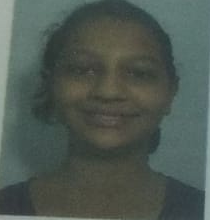

-1

In [59]:
from google.colab.patches import cv2_imshow
import cv2
# load the image and show it
image = cv2.imread("/content/sample.jpg")
cropped = image[180:400, 250:460]
cv2_imshow(cropped)
cv2.waitKey(0)

In [60]:
cropped

array([[[166, 174, 164],
        [165, 173, 163],
        [165, 173, 163],
        ...,
        [118, 121,  96],
        [120, 120,  96],
        [121, 121,  97]],

       [[166, 174, 164],
        [165, 173, 163],
        [165, 173, 163],
        ...,
        [117, 120,  95],
        [119, 119,  95],
        [120, 120,  96]],

       [[166, 174, 164],
        [165, 173, 163],
        [165, 173, 163],
        ...,
        [116, 119,  94],
        [119, 119,  95],
        [119, 119,  95]],

       ...,

       [[148, 152, 146],
        [147, 151, 145],
        [147, 151, 145],
        ...,
        [165, 165, 147],
        [164, 166, 147],
        [165, 167, 148]],

       [[153, 157, 151],
        [153, 157, 151],
        [152, 156, 150],
        ...,
        [164, 164, 146],
        [164, 166, 147],
        [165, 167, 148]],

       [[160, 164, 158],
        [159, 163, 157],
        [157, 161, 155],
        ...,
        [163, 163, 145],
        [163, 165, 146],
        [165, 167, 148]]

In [61]:
def findencoding(cropped):
  cropped=cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
  encode=face_recognition.face_encodings(cropped)
  return(encode)
encodelistknown=findencoding(cropped)
print(encodelistknown)

[array([-0.12840496,  0.02034676,  0.07268935, -0.0641347 , -0.02879328,
       -0.07480256,  0.04191001, -0.14427912,  0.17173405, -0.18061587,
        0.25118884, -0.06516907, -0.15408063, -0.09863773,  0.00417605,
        0.18754512, -0.13364895, -0.17253783, -0.11640032, -0.08968641,
       -0.06582955, -0.04675296,  0.06610873,  0.08890349, -0.14538163,
       -0.35934049, -0.07234474, -0.16541712, -0.04041683,  0.01450182,
       -0.02733304,  0.13641131, -0.23168609, -0.05396285, -0.02042741,
        0.08736348, -0.00310043,  0.02420481,  0.15661177, -0.01886386,
       -0.21626019,  0.00658553,  0.03410823,  0.2202103 ,  0.22867313,
       -0.00941192,  0.04015687, -0.09399818,  0.05171184, -0.24512154,
        0.03956652,  0.05250767,  0.0573694 ,  0.02854112,  0.01685039,
       -0.12457073,  0.00058012,  0.03893421, -0.19527116, -0.006374  ,
        0.00310972, -0.08585083, -0.09037306, -0.04422106,  0.26062891,
        0.19836628, -0.09986421, -0.09868948,  0.26323876, -0.1

In [62]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


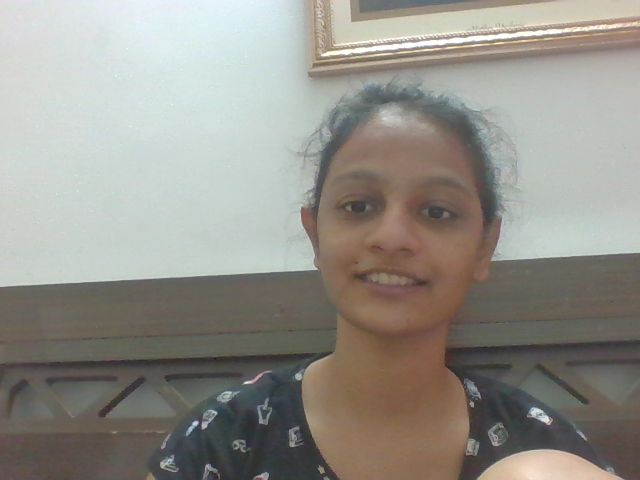

In [66]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [67]:
def read_img(p):
  img=cv2.imread(p)
  (h,w)=img.shape[:2]
  width=500
  ratio=width/float(w)
  height=int(h*ratio)
  return cv2.resize(img, (width, height))

p='/content/photo.jpg'
imgs=read_img(p)
imgs=cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)

facescurrframe=face_recognition.face_locations(imgs)
encodecurrframe=face_recognition.face_encodings(imgs,facescurrframe)


imgs=read_img(p)
imgs=cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)

facescurrframe=face_recognition.face_locations(imgs)
encodecurrframe=face_recognition.face_encodings(imgs,facescurrframe)

for encodeface,faceloc in zip(encodecurrframe, facescurrframe):
  matches=face_recognition.compare_faces(encodelistknown, encodeface)
  facedistance=face_recognition.face_distance(encodelistknown, encodeface)
  print(facedistance)
  

[0.46050738]


In [68]:
actualbdate=str(input())
actualgender=str(input())
if (actualbdate==birth and facedistance<0.5):
  print("Authentication Passed")
else:
  print("Enter the Correct information ")

1999
Female
Authentication Passed
